In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(0)

In [2]:
# Feature lists
standard_features = ["DMP_5", "DMP_10", "DMN_5", "DMN_10", "MACD_8_21_5", "AO_5_10",
    "EMA_15", "MA_20", "KAMA_3_2_10", "CO", "C2O2", "C3O3",
    "net_add_ask_size", "net_add_bid_size", "Bollinger_Upper", "Bollinger_Lower", "mid_price_volatility"
]

minmax_features = [
    "ADX_10", "ADX_7", "ADX_5", "STOCHk_7_3_3", "STOCHd_7_3_3", "RSI_7", "time_since_open"
]

unscaled_features = ['market_session']
features = standard_features + minmax_features + unscaled_features

In [3]:
sampling_rate = "1s"
prediction_column = "mid_price_variation_class"
batch_size = 16
look_back = 32

In [4]:
from tf_preprocessing import process_and_combine_data

start_date = "2024-10-02"
end_date = "2024-10-04"

all_data = process_and_combine_data(start_date, end_date, data_folder="../AAPL_data", sampling_rate=sampling_rate)

print(all_data.columns)

all_data.head()

Index(['trade_ask_size', 'trade_bid_size', 'net_add_ask_size',
       'net_add_bid_size', 'mid_price_first', 'mid_price_high',
       'mid_price_low', 'mid_price_last', 'close', 'high', 'low', 'open',
       'mid_price_variation', 'mid_price_variation_class',
       'mid_price_volatility', 'Returns', 'Target_close', 'ADX_5', 'ADX_7',
       'ADX_10', 'DMP_5', 'DMP_10', 'DMN_5', 'DMN_10', 'AROONU_7', 'AROOND_7',
       'OLL3', 'OLL5', 'OLL10', 'OLL15', 'OHH3', 'OHH5', 'STOCHk_7_3_3',
       'STOCHd_7_3_3', 'MACD_8_21_5', 'RSI_7', 'AO_5_10', 'EMA_15', 'HMA_10',
       'KAMA_3_2_10', 'MA_10', 'MA_20', 'rmCO(3)', 'rmCO(4)', 'rmCO(5)',
       'rmCO(6)', 'Bollinger_Upper', 'Bollinger_Lower', 'U_minus_L',
       'MA20dSTD', 'CO', 'C1O1', 'C2O2', 'C3O3', 'range', 'OH1',
       'time_since_open', 'dow_2', 'dow_3', 'dow_4', 'market_session'],
      dtype='object')


,trade_ask_size,trade_bid_size,net_add_ask_size,net_add_bid_size,mid_price_first,mid_price_high,mid_price_low,mid_price_last,close,high,...,C1O1,C2O2,C3O3,range,OH1,time_since_open,dow_2,dow_3,dow_4,market_session
ts_event,,,,,,,,,,,,,,,,,,,,,
2024-10-02 09:30:26-04:00,824.0,0.0,-477.0,434.0,225.875,225.880,225.860,225.870,225.85,225.86,...,0.095,-0.055,-0.010,0.020,0.110,26.0,1,0,0,0
2024-10-02 09:30:28-04:00,849.0,0.0,526.0,389.0,225.875,225.875,225.840,225.845,225.82,225.86,...,-0.005,0.095,-0.055,0.035,0.005,28.0,1,0,0,0
2024-10-02 09:30:30-04:00,1245.0,1007.0,-280.0,907.0,225.845,225.960,225.845,225.950,225.93,225.94,...,-0.030,-0.005,0.095,0.115,0.000,30.0,1,0,0,0
2024-10-02 09:30:31-04:00,0.0,0.0,-398.0,158.0,225.950,225.950,225.950,225.950,225.93,225.94,...,0.105,-0.030,-0.005,0.000,0.115,31.0,1,0,0,0
2024-10-02 09:30:33-04:00,2678.0,114.0,1417.0,-1324.0,226.000,226.000,225.915,225.915,225.90,225.99,...,0.000,0.105,-0.030,0.085,0.000,33.0,1,0,0,0


In [5]:
all_data.mid_price_variation_class.value_counts()

mid_price_variation_class
2.0    20070
0.0    19425
1.0    16736
Name: count, dtype: int64

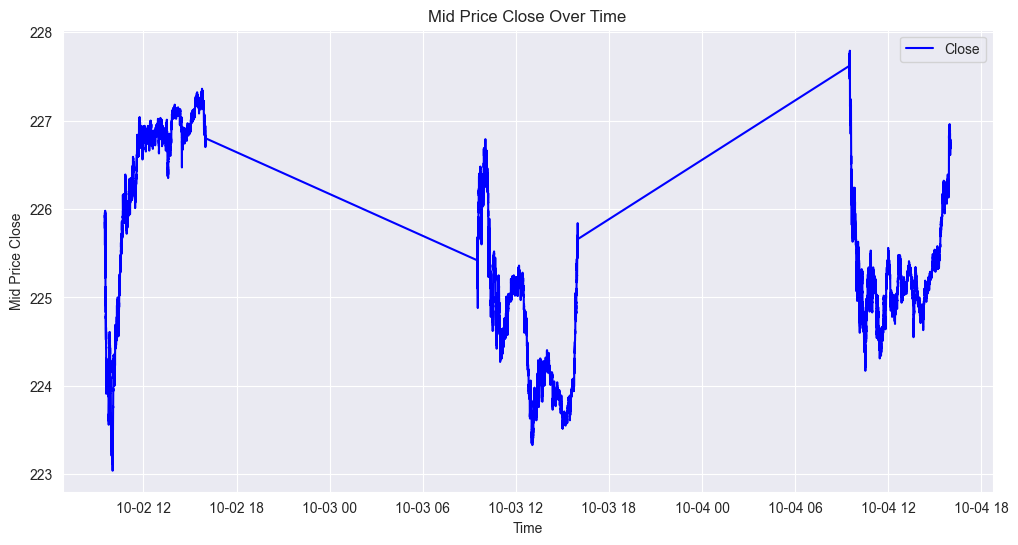

In [6]:
sns.set_style("darkgrid")

plt.figure(figsize=(12, 6))
plt.plot(all_data.index, all_data["close"], label="Close", color="blue")
plt.xlabel("Time")
plt.ylabel("Mid Price Close")
plt.title("Mid Price Close Over Time")
plt.legend()
plt.show()

In [7]:
# Data Splitting
train_size = int(len(all_data) * 0.7)
val_size = int(len(all_data) * 0.1)
test_size = len(all_data) - train_size - val_size

train_df = all_data.iloc[:train_size, :]
val_df = all_data.iloc[train_size:train_size + val_size, :]
test_df = all_data.iloc[train_size + val_size:, :]

In [8]:
from time_series_generators import  TimeSeriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Fit scalers on training data only
standard_scaler = StandardScaler().fit(train_df[standard_features])
minmax_scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_df[minmax_features])

# Apply scalers to training, validation, and test sets
train_scaled = np.hstack([
    standard_scaler.transform(train_df[standard_features]),
    minmax_scaler.transform(train_df[minmax_features]),
    train_df[unscaled_features].values
])

val_scaled = np.hstack([
    standard_scaler.transform(val_df[standard_features]),
    minmax_scaler.transform(val_df[minmax_features]),
    val_df[unscaled_features].values
])

test_scaled = np.hstack([
    standard_scaler.transform(test_df[standard_features]),
    minmax_scaler.transform(test_df[minmax_features]),
    test_df[unscaled_features].values
])

# Extract targets separately
train_target = train_df[prediction_column].values
val_target = val_df[prediction_column].values
test_target = test_df[prediction_column].values

# Create generators with pre-scaled data
train_gen = TimeSeriesGenerator(train_scaled, train_target, look_back=look_back, batch_size=batch_size)
val_gen = TimeSeriesGenerator(val_scaled, val_target, look_back=look_back, batch_size=batch_size)
test_gen = TimeSeriesGenerator(test_scaled, test_target, look_back=look_back, batch_size=batch_size)

In [9]:
from keras import layers, models, optimizers

def create_model():
    input_size = len(features)
    inputs = layers.Input(shape=(look_back, input_size))

    # First LSTM layer
    x = layers.LSTM(128, return_sequences=True)(inputs)
    x = layers.BatchNormalization()(x)

    # Second LSTM layer
    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # Dense layers
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(3, activation="softmax")(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

num_models = 1
epochs = 3
all_predictions = []

for i in range(num_models):
    model = create_model()
    optimizer = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    
    model.fit(train_gen, validation_data=val_gen, epochs=epochs)
    
    predictions = model.predict(test_gen)
    all_predictions.append(predictions)


Epoch 1/3
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - accuracy: 0.3991 - loss: 1.1580 - val_accuracy: 0.3697 - val_loss: 1.2002
Epoch 2/3
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.4440 - loss: 1.0555 - val_accuracy: 0.3813 - val_loss: 1.4681
Epoch 3/3
2459/2459 ━━━━━━━━━━━━━━━━━━━━ 51s 21ms/step - accuracy: 0.4830 - loss: 1.0183 - val_accuracy: 0.3481 - val_loss: 1.5459
701/701 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step


In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def plot_evaluation_metrics(y_true, y_pred, log_probabilities):
    probabilities = np.exp(log_probabilities)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Confusion Matrix (updated for 3 classes)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=axes[0],
        xticklabels=["Down (0)", "Constant (1)", "Up (2)"],  # Updated class labels with meaning
        yticklabels=["Down (0)", "Constant (1)", "Up (2)"],  # Updated class labels with meaning
    )
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")

    # Histogram of Predicted Probabilities (updated for 3 classes)
    for i, class_label in enumerate(["Down (0)", "Constant (1)", "Up (2)"]):  # Updated class labels with meaning
        sns.histplot(
            probabilities[y_true == i][:, i], bins=30, label=class_label, ax=axes[1]
        )
    axes[1].set_title("Probability Distribution")
    axes[1].set_xlabel("Predicted Probability")
    axes[1].legend()

    # Scatter Plot of Predictions (updated for 3 classes)
    scatter = sns.scatterplot(
        x=np.arange(len(probabilities)),
        y=probabilities.max(axis=1),
        hue=y_true,
        palette={0: "red", 1: "blue", 2: "green"},  # Updated palette for 0, 1, 2
        alpha=0.7,
        ax=axes[2],
    )
    axes[2].set_title("Scatter Plot of Predictions")
    axes[2].set_xlabel("Sample Index")
    axes[2].set_ylabel("Max Predicted Probability")

    handles, labels = scatter.get_legend_handles_labels()
    new_labels = ["Down (0)", "Constant (1)", "Up (2)"]  # Updated class labels with meaning
    axes[2].legend(handles, new_labels, title="True Class")

    axes[2].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

    # Print Evaluation Metrics
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred, zero_division=0))

In [11]:
# Convert predictions to class labels
all_predictions = np.array(all_predictions)
predicted_classes = np.argmax(all_predictions, axis=-1)

# Majority voting
final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predicted_classes)

# Compute log probabilities for evaluation
log_probabilities = np.log(np.mean(all_predictions, axis=0))

# Evaluate the final predictions
y_true = test_gen.true_labels  # Assuming test_gen has the true labels
plot_evaluation_metrics(y_true, final_predictions, log_probabilities)

AttributeError: 'TimeSeriesGenerator' object has no attribute 'true_labels'

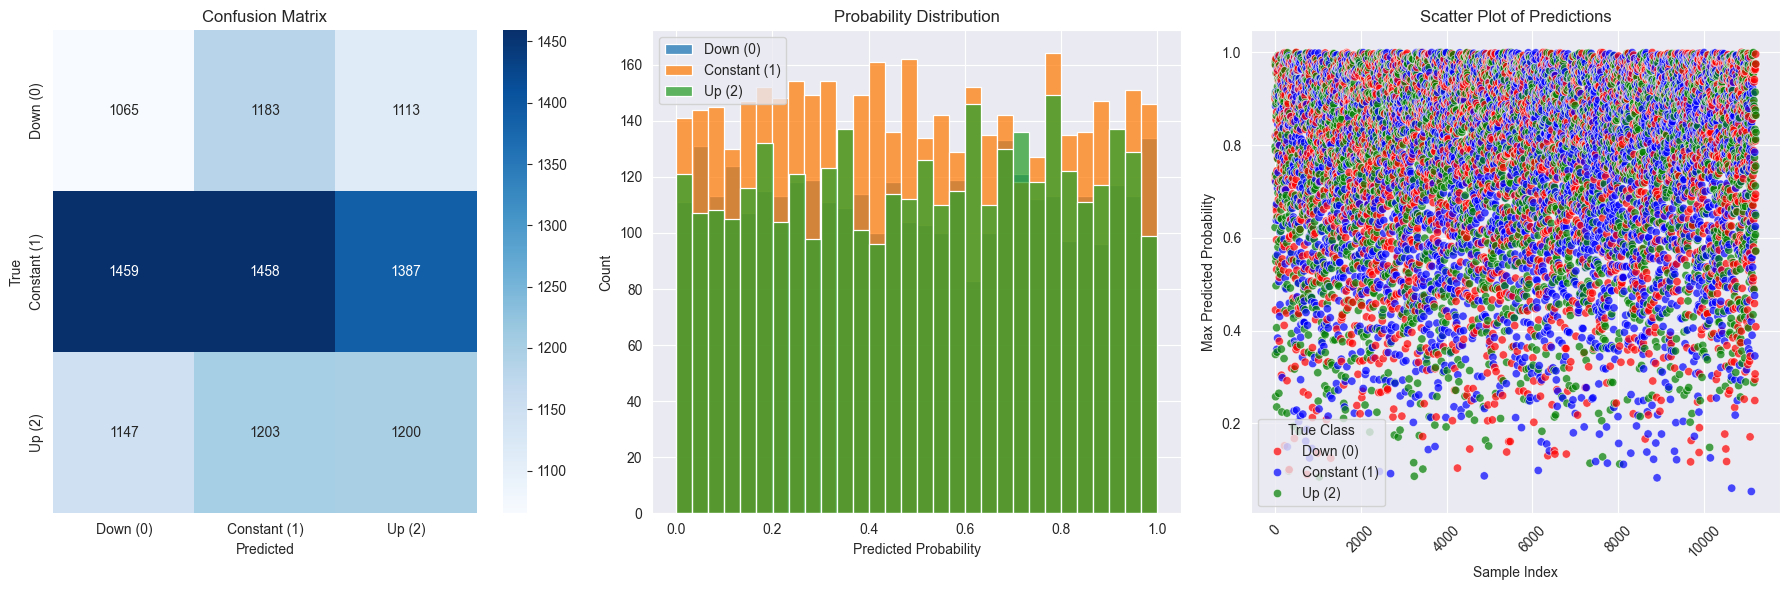

Accuracy: 0.3320
              precision    recall  f1-score   support

           0       0.29      0.32      0.30      3361
           1       0.38      0.34      0.36      4304
           2       0.32      0.34      0.33      3550

    accuracy                           0.33     11215
   macro avg       0.33      0.33      0.33     11215
weighted avg       0.34      0.33      0.33     11215



In [ ]:
# Implement a random strategy
random_y_pred = np.random.randint(0, 3, size=len(final_predictions))
random_log_probabilities = np.log(np.random.rand(len(final_predictions), 3))

# Plot evaluation metrics for the random strategy
plot_evaluation_metrics(final_predictions, random_y_pred, random_log_probabilities)